# Exploring Rebound gravity package

This notebook works out the conventions in Rebound by setting up some simple 2 and 3 body systems.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import rebound as rb

### Units and Parameters
Rebound uses units with $G=1$ as default.  $G$ has dimensions $M^{-1}L^{3}T^{-2}$, so our unit system ($M$, $L$, $T$) is constrained by $M T^2 L^{-3} = \text{const}$ and we have the freedom to set two of the scales while still using $G=1$.  To normalize this, note that the period of an Keplerian test-particle in orbit with a semi-major axis $a$ about a mass $M$ is $T^2 = 4\pi^2 a^3/GM$, and so $G$ can be written:

$ G = 4 \pi^2 \frac{\text{A.U.}^3}{M_\odot \text{Year}^2} $

and our units obey:

$ \frac{M}{M_\odot} \left(\frac{T}{\text{Year}}\right)^2 \left(\frac{\text{A.U.}}{L}\right)^3 = 4\pi^2 $

In general, specifing a binary requires 2 masses $M_1$, $M_2$, a radius $a$ (or some sort of semi-major axis in the non-ciruclar case), and eccentricity $e$ (cirlcular binary has $e=0$, unbound binary has $e\geq1$).  The above unit system has freedom to set $M_T = M_1 + M_2 = 1$ and $a = 1$, and then $G=1$ fixes the orbial period to be $2\pi$ in these units. So we can specify the binary with two bounded parameters: eccentricity and a mass ratio $\eta$, say the ratio of the mass of the larger body to the total mass,
$$ 0 \leq e < 1 $$
$$ 0.5 \leq \eta \leq 1 $$

The above specification sets the units for any body in addition to the binary, with mass measured relative to $M_T$, length scales by $a$, time relative to the binary period $T/2\pi$.  Velocities are specfied relative to $2\pi a/T$, which for a circular binary is the binary's velocity, and for an elliptical binary is some more subtle velocity scale that is order 1 the typical binary velocity.


### Eccentricities  and Scales 
Specifing sensible scales is straightforward for a circular binary, but a bit tricky in the elliptical case. We probably won't need to consider elliptical binaries, but regardless I will work thought it be sure I understand the Rebound conventions correctly. 

The clean aproach is to consider the 1-body reduced problem, and describe the system's length scale as the semi-major axis $a$ of that ellipse (in astronomer lingo: "use Jacobi cordinates"). This is what Rebound does (from their documentation: "we use Jacobi coordinates"). The degree of freedom under consideration in the reduced problem is $\vec{r} = \vec{r}_1 - \vec{r}_2$, the seperation between the binaries. The reduced result is that $\vec{r}$ traces out an ellipse with one focus on the origin. What does the reduced $a$ correspond to physically?  It is the difference between the maximum and minimum signed seperations between the particles, or it can be related to the time averaged seperation between the particles or other such slighly awkward quantities. 

I want to use as a fixed length scale something that can be obviously read from a plot of orbits in physical space, to ensure that I am initalizing the orbits properly.  I'll use the maximum seperation between the binary members.  In the reduced picture, this correspondes to the maximum length of $\vec{r}$, which is the maximum distance of the reduced ellipse from its focus.  For semi-major axis $a$ and eccentricity $e$, this is $d = a (1 + e)$.  So to fix the maximum physical seperation at $1$, for a given eccentricity set the reduced semi-major axis to $(1 + e)^{-1}$ 

This also effects the orbital period, which for reduced semi-major axis $a$ and *any* eccentricity is $T^2 = 4 \pi^2 a^3/G M_T$.  In our units, with maximum physical seperation fixed to $d = 1$, the period is $T = 2 \pi (1 + e)^{-3/2}$.  If we had fixed $a$ instead of $d$, we would have a fixed orbital period but varying maximum physical seperation while $e$ varies. Note that for $e\neq0$, the rotational frequency is not constant. 

In [2]:
def sim_binary(h, e, samples=50):
    """
    Simulate for 1 period a binary of eccentricy e and mass-ratio h.
    Samples gives the number of state measurments to output during 1 period. 
    In output, the first body is the more massive one and the second body the less massive. 
    """
    M1, M2 = h, 1 - h
    T = 2*np.pi/(1.0 + e)**1.5  # 1 period
    sim = rb.Simulation()
    sim.add(m=M1)  # more massive body
    sim.add(m=M2, a=1.0/(1.0 + e), e=e)
        # This starts the less massive body in an oribt with a reduced semi-major axis and eccencity 
        # such that the physical binary orbits will have a maximum seperation of 1. 
        # Since this specifies the second body's initial orbit relative to the first body's 
        # position, the first body's initial oribt is now fixed and doesn't need specification.
        # By default, the major and minor axes of orbit are aligned with x and y axes, with motion counterclockwise
        # and the starting phase of the reduced ellipse at 0 (particles initially along the x-axis). 
    sim.move_to_com()
    sample_times = np.linspace(0, T, samples)
    num_particles = 2
    num_dims = 3
    positions = np.zeros((num_particles, num_dims, samples))
    for time_index, t in enumerate(sample_times):
        sim.integrate(t) # advance binary to time t
        for particle_index, particle in enumerate(sim.particles):
            positions[particle_index, :, time_index] = [particle.x, particle.y, particle.z]
    return positions, sample_times

In [3]:
def plot_binary(positions, times):
    ''' 
    Plot binary trajectories.
    Time evolution shown by fading - initially transparent evolving to solid (assumes only 1 peroid to be shown)
    First particle is red, second is blue. 
    '''
    [x1, y1, z1], [x2, y2, z2] = positions
    alphas = times/times.max()
    red, blue = [1, 0, 0], [0, 0, 1]
    redfade  = np.asarray([red  + [a] for a in alphas])
    bluefade = np.asarray([blue + [a] for a in alphas])  # rgba colors, fade ~ time
    fig, ax = plt.subplots()
    ax.scatter(x1, y1, marker='o', color=redfade)
    ax.scatter(x2, y2, marker='o', color=bluefade)
    ax.plot(0, 0, marker='o', color='k', alpha=1)  # COM
    ax.set_aspect('equal')
    ax.set_title("orbits")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig, ax = plt.subplots()
    seperation = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    ax.plot(times, seperation, marker='')
    ax.axhline(0, linestyle='--', alpha=0.4)
    ax.axhline(1, linestyle='--', alpha=0.4)
    ax.set_ylim(-0.2, 1.2)
    ax.set_ylabel("binary seperation")
    ax.set_xlim(-0.5, 2*np.pi + 0.5)
    ax.set_xlabel("time")

### 1-body examples
Should be counterclockwise ellipses of horizontal width 2 (semi-major axis 1).

eccentricity 0
eccentricity 0.1
eccentricity 0.5
eccentricity 0.95


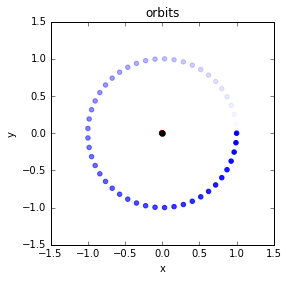

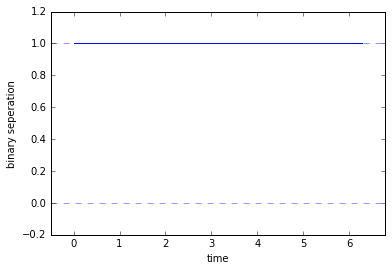

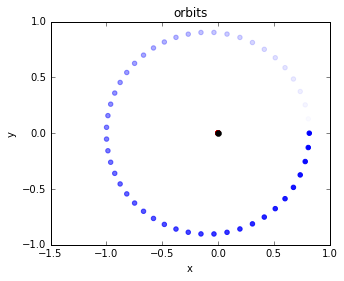

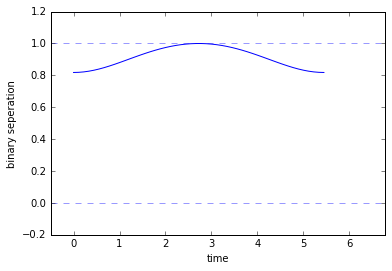

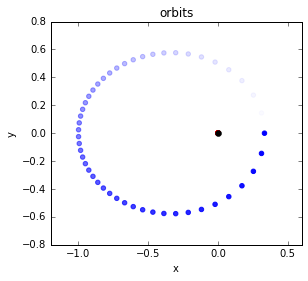

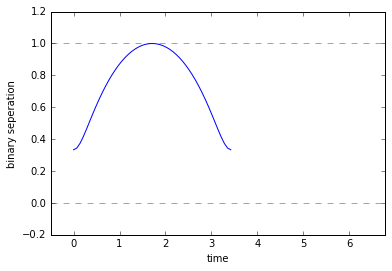

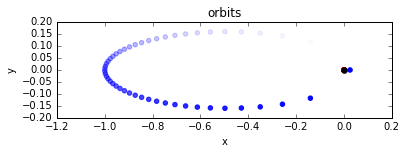

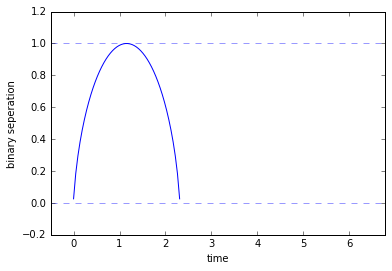

In [4]:
es = [0, 0.1, 0.5, 0.95]
for e in es:
    print "eccentricity {}".format(e)
    plot_binary(*sim_binary(1, e))

### equal mass binaries

Should be pairs of counterclockwise ellipses bounded at $x=\pm0.5$, with parity symmetry.

eccentricity 0
eccentricity 0.1
eccentricity 0.5
eccentricity 0.95


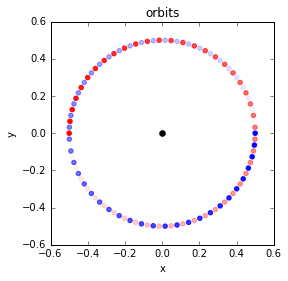

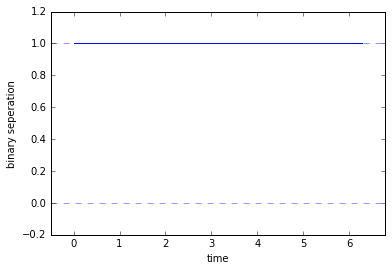

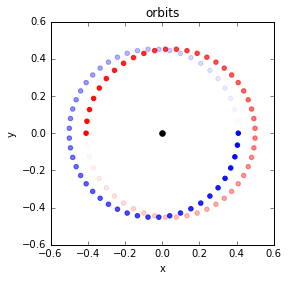

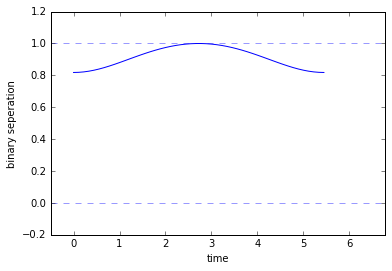

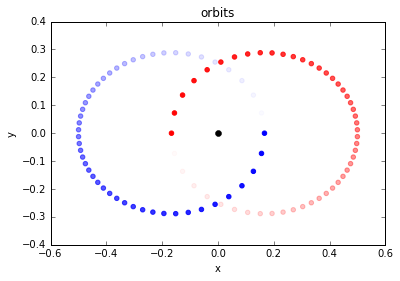

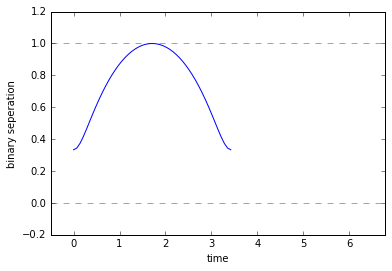

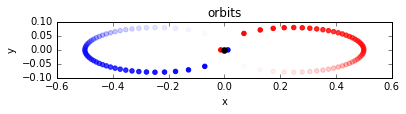

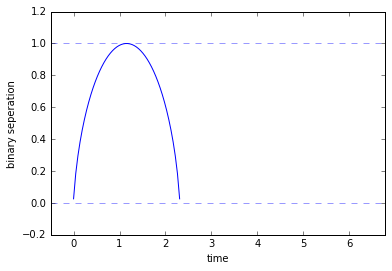

In [5]:
es = [0, 0.1, 0.5, 0.95]
for e in es:
    print "eccentricity {}".format(e)
    plot_binary(*sim_binary(0.5, e))

### asymmetric binaries
Now an asymmetic pair of counterclockwise ellipses, where the distance from one ellipse edge to the other ellipse's opposite edge is 1. The red orbit is the more massive particle, and should be the inner oribt. 

eccentricity 0
mass-ratio 0.6
eccentricity 0
mass-ratio 0.9
eccentricity 0.1
mass-ratio 0.6
eccentricity 0.1
mass-ratio 0.9
eccentricity 0.5
mass-ratio 0.6
eccentricity 0.5
mass-ratio 0.9
eccentricity 0.95
mass-ratio 0.6
eccentricity 0.95
mass-ratio 0.9


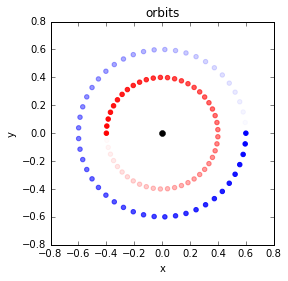

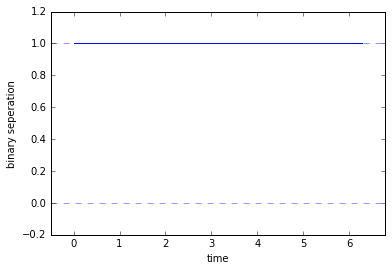

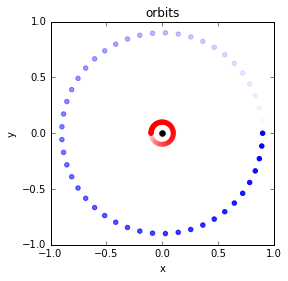

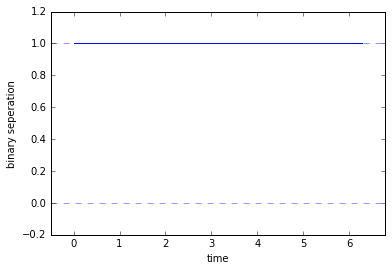

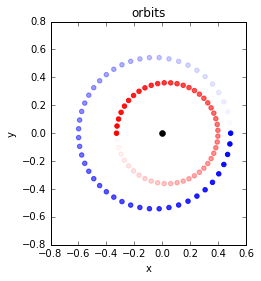

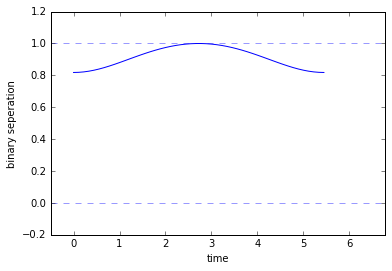

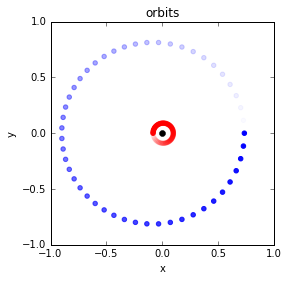

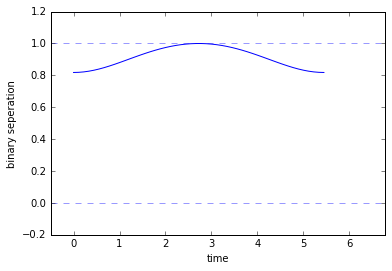

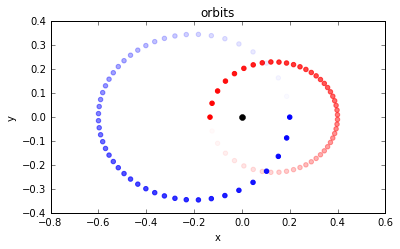

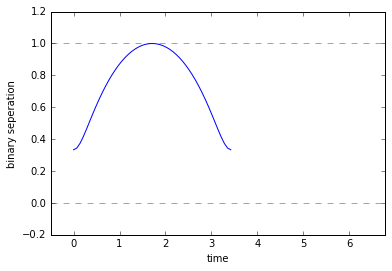

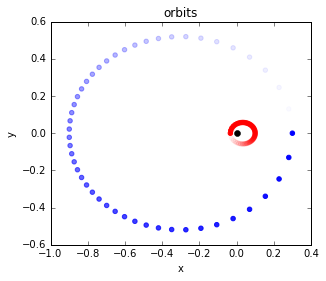

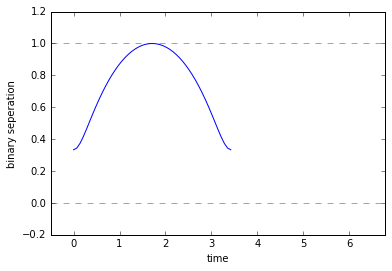

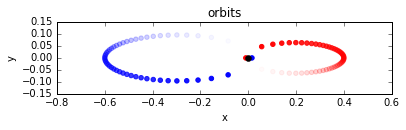

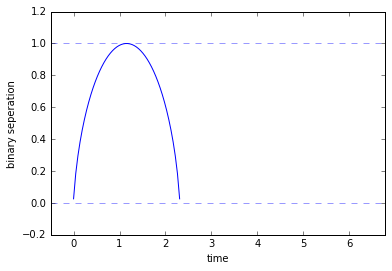

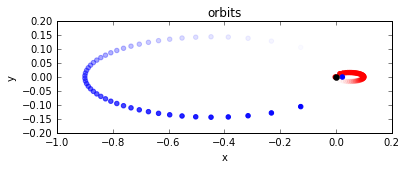

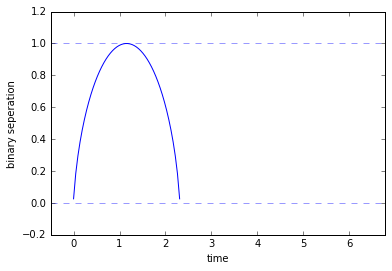

In [6]:
es = [0, 0.1, 0.5, 0.95]
hs = [0.6, 0.9]
for e in es:
    for h in hs:
        print "eccentricity {}".format(e)
        print "mass-ratio {}".format(h)
        plot_binary(*sim_binary(h, e))

### Jacobi Cooordinates and Orbits for 2 + n Bodies

Additional bodies can be added with orbits specified in Jacobi coordinates. The Jacobi scheme is: measure the motion of the second body relative to the first body, and the motion of the nth (n > 2) body relative to the center of mass of the first n - 1 bodies. This is very slick if the bodies have a hierarchy of masses (as ours do!).  A third body added to the simulation will be specified relative to the COM of the binary.  A fourth would nominally be specified relative to the COM of the first three bodies, but since Rebound allows adding true zero-mass test particles, we can add a whole host of test bodies and all will be specfied relative to the binary COM.

In a 2 + n body system, the orbit of a body as recorded in Rebound is the instantaneous Kepler orbit about the reference point, which by default is chosen by the Jacobi scheme. This may be useful for us, as far from the binary or very close to one body, the particles ought to travel on a roughly fixed Kepler hyperbola.

### Hyperbolic Orbits

How to specify a hyperbolic orbit?  For a test particle incident on a point mass $M$ from $\infty$ with velocity $v$ and impact parameter $b$, the orbital parameters are:
$$ a = - \frac{GM}{v^2} $$
$$ e^2 - 1 = \left( \frac{b v^2}{GM} \right)^2 = \left( \frac{b}{a} \right)^2$$
Note that for a hyperbola, the semi-major axis is negative and $e>1$ ($e=1$ is the parabola).  In our units, 
$$ a = - v^{-2} $$
$$ e^2 - 1 = b^2 v^4 = b^2/a^2 $$

The opening half-angle $\psi$ of the hyperbola is set by the eccentricity (see Valtonen-Karttunen 3.13): 
$$ \psi = \arccos\left(\frac{1}{e}\right)$$
For a limmiting ellipse, $e=1$ and the opening angle is 0 - this is a degnerate radial line terminating at the orgin. For $e \rightarrow \infty$, the full opening angles is $2\psi = \pi$ and we have a degenerate full line (this correspondes to the limit $bv^2 \rightarrow \infty$). The *scattering angle* $\theta$ is the asympotic deviation of the hyperbola from a straight line, so $\theta = \pi - 2\psi = 2\arcsin \left(\frac{1}{e}\right)$.

#### Orbital Parameters for $x\left(t=-\infty\right)=-\infty$ Scattering Orbits  
A particle entering from $x=-\infty$ with impact parameter $b>0$ follows a clockwise orbit, while astronomy convention is that *all* orbits move counter-clockwise in their orbital plane.  The angle between the orbial plane's normal and the $xy$ plane is the *inclination* $i$, so a clockwise orbit is has $i=\pi$.  The oribtal plane by default intersects the $xy$ plane along the x-axis (this is controlled by the *longitude of the ascending node*, which be default is zero), and so for $b>0$ the oribtal plane is the $xy$ plane reflected across the x-axis.  For a negative impact parameter, the orbit is counter-clockwise, so $i=0$ and the oribal plane is the $xy$ plane. 

The angle of the extremal point of the hyperbola with the x-axis is the *argument of periastron* $W$, which by default is zero. A hyperbolic orbit that approaches from $x=-\infty$ should have an initial asymptote parallel to the x-axis, so we need to rotate the default orbit by half the hyperbola's opening angle, i.e. rotate by $\psi$ above. The sense of $W$ is to increase counter-clockwise about the normal to the orbital plane.  For $b>0$ the orbital plane is reflected relative to the $xy$ plane, so to rotate by $\psi$ in the $xy$ plane we need to set $W=-\psi$.  For $b<0$, the oribtal plane is the $xy$ plane but now need to rotate by $-\psi$ in $xy$ since the initial leg of the orbit is below the x-axis, and so we again need $W=-\psi$. 

In summary, for a scattering orbit aproaching a mass $M=1$ at the origin with velocity $v$ and impact parameter $b$:
$$ a = - v^{-2} $$
$$ e = \sqrt{1 + b^2/a^2} $$
$$ W = -\arccos\left(\frac{1}{e}\right) $$
$$ i = \pi\theta\left(-b\right) $$

In [17]:
def sim_scatter(b, v, elapsed=2, samples=50):
    """
    Simulate a test-particle scattering orbit starting at x=-infinity with impact parameter b and velocity v,
    approaching a fixed mass M=1 at the origin. 
    The orbit will be sampled between -0.5*elapsed*T and 0.5*elapsed*T, where time=0 correspondes to the
    point of closest aproach and T is the Kepler time scale of the orbit. 
    Samples gives the number of state measurments to output.
    """
    b, v, elapsed = float(b), float(v), float(elapsed)
    samples = int(samples)
    sim = rb.Simulation()
    sim.add(m=1)  # fixed mass
    a = -1.0/v**2  # hyperbolic semi-major axis
    e = np.sqrt(1 + b**2/a**2)  # eccentricity
    psi = -np.arccos(1.0/e)  # angle of closest approach
    inc = np.pi if b > 0 else 0.0  # get clockwise oribt for b > 0
    sim.add(a=a, e=e, omega=psi, inc=inc) # no m specified -> test particle
    sim.move_to_com()
    T = 2*np.pi*np.absolute(a)**1.5  # 1 "period"
    sample_times = np.linspace(-0.5*elapsed*T, 0.5*elapsed*T, samples)
    num_particles = 2
    num_dims = 3
    positions = np.zeros((num_particles, num_dims, samples))
    for time_index, t in enumerate(sample_times):
        sim.integrate(t) # advance binary to time t
        for particle_index, particle in enumerate(sim.particles):
            positions[particle_index, :, time_index] = [particle.x, particle.y, particle.z]
    return positions, sample_times

def plot_scatter(b, positions, times):
    ''' 
    Plot scattering trajectory.
    Time evolution shown by fading - initially transparent evolving to solid.
    Test particle in blue, COM particle in black.
    '''
    [x1, y1, z1], [x2, y2, z2] = positions
    fig, ax = plt.subplots()
    alphas = (times - times.min())/(times.max() - times.min())
    blue = [0, 0, 1]
    bluefade = np.asarray([blue + [a] for a in alphas])  # rgba colors, fade ~ time
    ax.scatter(x1, y1, marker='o', color='k')
    ax.scatter(x2, y2, marker='o', color=bluefade)
    ax.plot(x2[0], y2[0], 'b.')
    ax.axhline(b, color='b')  # initial asymptote
    ax.axhline(0, color='k')  # x-axis
    if b > 0:
        ax.set_ylim(-b - 1, b + 1)
    elif b < 0:
        ax.set_ylim(b - 1, -b + 1)
    ax.set_aspect("equal")
    ax.set_title("scattering orbit")
    ax.set_xlabel("x")
    ax.set_ylabel("y")

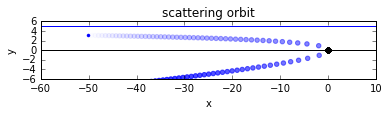

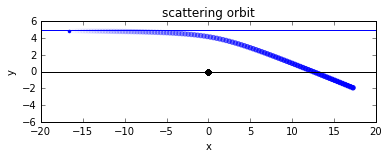

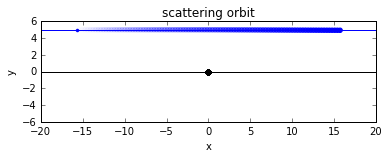

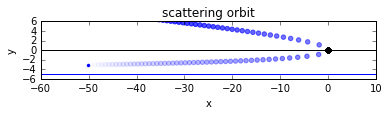

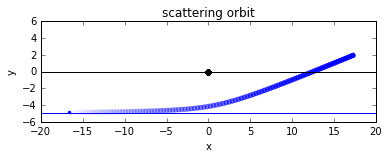

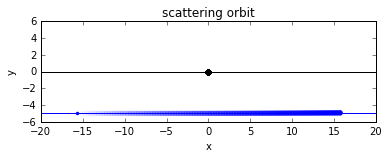

In [29]:
impacts = [5, -5]
velocities = [0.1, 1, 10]
for b in impacts:
    for v in velocities:
        plot_scatter(b, *sim_scatter(b, v, samples=100, elapsed=5*v**2))
        # time scale ~ v**2 determined by trial and error